## Thermal Conductivity Fit Analysis
### Developed by Henry Nachman
#### Last Edited: 26 January 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, string, csv, h5py, yaml
from scipy.special import erf


First, we need to find where all our RAW data is

In [2]:
path_to_lib = f"{os.getcwd()}\\lib"
mat_directories = [folder for folder in os.listdir(path_to_lib) if not folder.endswith(".md")]

path_to_RAW = dict()
for mat in mat_directories:
    raw_str = f"{path_to_lib}\\{mat}\\RAW"
    path_to_RAW[mat] = raw_str


print(path_to_RAW)

{'SS304': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS304\\RAW', 'SS305': 'c:\\Users\\henac\\OneDrive - The University of Texas at Austin\\01_RESEARCH\\05_CMBS4\\Cryogenic_Material_Properties\\thermal_conductivity\\lib\\SS305\\RAW'}


Next, we need to extract each file.

In [3]:
def get_datafiles(raw_path):
    all_files = os.listdir(raw_path)
    extension = ".csv"
    raw_files = [file for file in all_files if file.endswith(extension)]
    print(f"Found {len(raw_files)} measurements.")
    return raw_files

Now, lets parse the data from the csv files

In [4]:
def parse_raw(material_name, path_dict, plots=False):
    raw_directory = path_dict[material_name]
    all_files = os.listdir(raw_directory)
    extension = ".csv"
    raw_files = [file for file in all_files if file.endswith(extension)]
    
    big_data = np.empty((0,3), float)
    data_dict = dict()
    for f in raw_files:
        f_path = raw_directory +"\\"+ f
        file1 = np.loadtxt(f_path, dtype=str, delimiter=',')
        ref_row = file1[0]
        ref_name = f[:-4]
        raw_data = np.array(file1[2:,:], dtype=float)
        big_data = np.append(big_data, raw_data, axis=0)
        data_dict[ref_name] = raw_data
        T, k, koT = raw_data.T
        if plots:
            plt.plot(T, k, '.', label=ref_name)
    if plots:
        plt.legend()
        plt.xlabel("Temperature")
        plt.ylabel("k")
        plt.semilogx()
        plt.semilogy()
        plt.savefig(f"{os.path.split(raw_directory)[0]}\\{material_name}.pdf", dpi=300, format="pdf")
        plt.show()
        plt.clf()

    return big_data, data_dict

This function will fit the data to polynomials. The fit is done in two stages, a low end fit and a high end fit. Currently there is not resolution of the discontinuity between the two.

In [5]:
def fit_thermal_conductivity(big_data, save_path, thresh = 20, fit_orders = (2,3), fit_types=("k/T", "loglog"), plots=False):
    # thresh     : 20    : The temperature threshold to split low and high data   
    # fit_orders : (2,3) : The polynomial order for the low and high fits respectively

    # divide the data array into three columns
    T = big_data[:,0]
    k = big_data[:,1]
    koT = big_data[:,2]

    # Set a temperature threshold for split between hi and low fits
    thresh = 20 # in K

    # Find the low range
    lowT = T[T<thresh]
    lowT_k = k[T<thresh]
    lowT_koT = koT[T<thresh]

    # Find the high range
    hiT = T[T>thresh]
    hiT_k = k[T>thresh]
    # Take a log10 of the high range
    log_hi_T = np.log10(hiT)
    log_hi_k = np.log10(hiT_k)

    # Fit the low data
    if fit_types[0] == "k/T":
        low_fit = np.polyfit(lowT, lowT_koT, fit_orders[0])
        low_fit_xs = np.linspace(np.min(lowT), np.max(lowT), 100)
        low_poly1d = np.poly1d(low_fit)


    # Fit the high data
    if fit_types[1] == "loglog":
        hi_fit = np.polyfit(log_hi_T, log_hi_k, fit_orders[1])
        hi_fit_xs = np.linspace(np.min(log_hi_T), np.max(log_hi_T), 100)
        hi_poly1d = np.poly1d(hi_fit)


##################################################################

    from scipy.special import erf

    erf_place = 20
    xrange_total = np.linspace(min(lowT), max(hiT), 100)
    erfTerm_low = (0.5*(1-erf(15*(np.log10(xrange_total/erf_place)))))
    low_term = (np.log10(np.abs(xrange_total*low_poly1d(xrange_total))))*erfTerm_low

    erfTerm_hi = (0.5*(1+erf(15*(np.log10(xrange_total/erf_place)))))
    hi_term = (hi_poly1d(np.log10(xrange_total)))*erfTerm_hi
    logk =  low_term + hi_term 


##################################################################


    if plots:
        fig, axs = plt.subplots(2, figsize=(8, 6))
        axs[0].plot(lowT, lowT_koT,'.')
        axs[0].plot(low_fit_xs, np.polyval(low_fit, low_fit_xs))
        axs[0].set_xlabel("T")
        axs[0].set_ylabel("k/T")
        axs[0].title.set_text("Low Temperature Fit")
        axs[1].loglog(10**hi_fit_xs, 10**np.polyval(hi_fit, hi_fit_xs))
        axs[1].loglog(hiT, hiT_k, '.')
        axs[1].grid(True, which="both", ls="-", color='0.65')
        axs[1].set_ylabel("k")
        axs[1].set_xlabel("T")
        axs[1].title.set_text("High Temperature Fit")
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.savefig(f"{save_path}\\fitPlot.pdf", dpi = 300, format="pdf")
        plt.show()
        plt.clf()
        
    low_func = f"{fit_orders[0]} order {fit_types[0]}"
    hi_func = f"{fit_orders[1]} order {fit_types[1]}"
    
    low_param = np.array(low_fit)
    hi_param = np.array(hi_fit)
    all_params = np.append(np.append(low_param, hi_param), erf_place)

    arg_dict = {"low_function_type"  : low_func,
                "low_fit_param"      : low_param.tolist(),
                "low_fit_range"      : np.array([min(low_fit_xs), max(low_fit_xs)]).tolist(),
                "hi_function_type"   : hi_func,
                "hi_fit_param"       : hi_param.tolist(),
                "hi_fit_range"       : np.array([10**min(hi_fit_xs), 10**max(hi_fit_xs)]).tolist(),
                "combined_function_type" : "loglog",
                "combined_fit_param" : all_params.tolist(),
                "combined_fit_range" : np.array([min(lowT), max(hiT)]).tolist()}
    return arg_dict



Log10 k = Log10 [aT+bT^2+cT^3+3E-9T^5]*0.5*[1-ERF(15(Log10T-1.48)]+[d+eLog10T+f(Log10T)^2+g(log10T)^3+hEXP^(Log10T)]*0.5*[1+ERF(15(Log10T-1.48)]

SS304


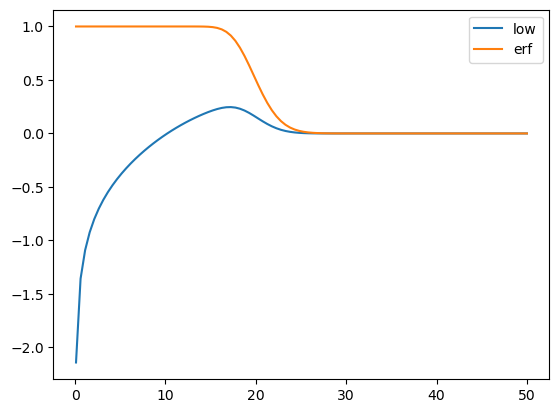

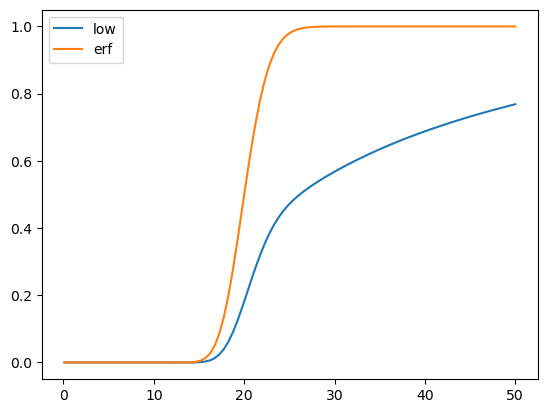

[-1.54712900e-05  3.58584811e-04  4.85897651e-04  7.21688050e-02
  2.18982647e-01 -1.62951342e+00  4.42077780e+00 -3.11247740e+00
  2.00000000e+01]


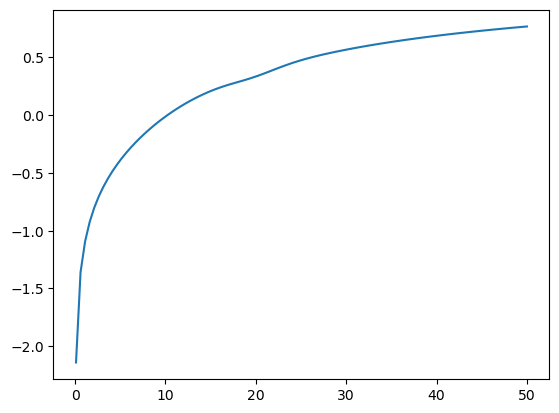

In [6]:
mat = "SS304"
print(mat)
big_data, data_dict = parse_raw(mat, path_to_RAW, plots=False)
fit_args = fit_thermal_conductivity(big_data, os.path.split(path_to_RAW[mat])[0], fit_orders=(3, 3) , plots=False)

low_param = fit_args["low_fit_param"]
hi_param = fit_args["hi_fit_param"]

xrange_low = np.linspace(0.1, 20, 100)
xrange_hi = np.linspace(20, 1300, 100)

low_y = np.poly1d(low_param)
hi_y = np.poly1d(hi_param)
# plt.plot(xrange_low, xrange_low*low_y(xrange_low))
# plt.plot(xrange_hi, 10**hi_y(np.log10(xrange_hi)))

erf_place = 20
xrange_total = np.linspace(0.1, 50, 100)
erfTerm_low = (0.5*(1-erf(15*(np.log10(xrange_total/erf_place)))))
low_term = (np.log10(np.abs(xrange_total*low_y(xrange_total))))*erfTerm_low

# for x in xrange_total:
#     print(x*low_y(x), np.log10(x*low_y(x)))
plt.plot(xrange_total, low_term, label="low")
plt.plot(xrange_total, erfTerm_low, label="erf")
plt.legend()
plt.show()


erfTerm_hi = (0.5*(1+erf(15*(np.log10(xrange_total/erf_place)))))
hi_term = (hi_y(np.log10(xrange_total)))*erfTerm_hi
plt.plot(xrange_total, hi_term, label="low")
plt.plot(xrange_total, erfTerm_hi, label="erf")
plt.legend()
plt.show()
# print(hi_term)
logk =  low_term + hi_term 
plt.plot(xrange_total, logk)


all_params = np.append(np.append(low_param, hi_param), erf_place)
print(all_params)

These functions allow for saving of the data to different file types.

In [13]:
def make_fit_yaml(fit_args, save_path):
    with open(f"{save_path}\\{os.path.split(save_path)[1]}.yaml", 'w') as file:
        for key in fit_args.keys():
            yaml.dump(key, file)
            yaml.dump(np.array(fit_args[key]).tolist(), file)
    return

def generate_alphabet_array(n):
    alphabet = list(string.ascii_lowercase)
    return alphabet[:n]
    
def make_fit_dict(fit_args):
    
    max_fit_param = 0
    num_fit_param_hi = len(fit_args["hi_fit_param"])
    num_fit_param_lo = len(fit_args["low_fit_param"])
    if (num_fit_param_hi > max_fit_param)|(num_fit_param_lo > max_fit_param):
        max_fit_param = max(num_fit_param_hi, num_fit_param_hi)

    # Example: Create an array of the first 5 letters of the alphabet
    n = max_fit_param
    result = generate_alphabet_array(n)
    result[-1] = "erf param"
    output_array = []
    keys = ["Fit Type", "Low", "High"] + result

    for i in ["low", "hi"]:
        dict_vals = []
        dict_vals = np.append(dict_vals, np.array(fit_args[f"{i}_function_type"], dtype=str).flatten())
        dict_vals = np.append(dict_vals, np.char.mod('%0.' + str(3) + 'f', np.array(fit_args[f"{i}_fit_range"], dtype=float)).flatten())
        param_str_arr  = np.append(dict_vals, np.char.mod('%0.' + str(5) + 'f', np.array(fit_args[f"{i}_fit_param"], dtype=float)).flatten())
        while len(param_str_arr) < len(result):
            param_str_arr = np.append(param_str_arr, "0")
        dict_vals = np.append(dict_vals, param_str_arr)

        mat_dict = dict(zip(keys, dict_vals))
        output_array.append(mat_dict)
        print(output_array)
    return output_array

def make_fit_dictm2(fit_args):
    
    max_fit_param = 0
    num_fit_param_hi = len(fit_args["hi_fit_param"])
    num_fit_param_lo = len(fit_args["low_fit_param"])
    num_fit_param_combined = len(fit_args["combined_fit_param"])

    # Example: Create an array of the first 5 letters of the alphabet
    n = num_fit_param_combined
    result = generate_alphabet_array(n)

    output_array = []
    keys = ["Fit Type", "Low Temp", "High Temp"] + result

    for i in ["low", "hi", "combined"]:
        dict_vals = []
        dict_vals = np.append(dict_vals, np.array(fit_args[f"{i}_function_type"], dtype=str).flatten())
        dict_vals = np.append(dict_vals, np.char.mod('%0.' + str(3) + 'f', np.array(fit_args[f"{i}_fit_range"], dtype=float)).flatten())
        param_str_arr  = np.char.mod('%0.' + str(5) + 'f', np.array(fit_args[f"{i}_fit_param"], dtype=float)).flatten()
        while len(param_str_arr) < len(result):
            param_str_arr = np.append(param_str_arr, "0")
        dict_vals = np.append(dict_vals, param_str_arr)
    
        mat_dict = dict(zip(keys, dict_vals))
        output_array.append(mat_dict)
        print(output_array)
    return output_array

def make_fit_lh5(fit_args, save_path):
    comp_file = f"{save_path}\\{os.path.split(save_path)[1]}.lh5"
    with h5py.File(comp_file, "w") as f:
        for key in fit_args:
            f.create_dataset(f"{key}", data=fit_args[key])
    return comp_file

This function makes a nice plot with the data and the fits.

In [8]:
def tk_plot(material_name, path_dict, data_dict, fit_args, points=True):
    raw_directory = path_dict[material_name]
    markers = ['o', 's', 'd', 'P','3', '*']
    i = 0
    if points:
        for ref_name in data_dict.keys():
            T, k, koT = data_dict[ref_name].T
            plt.plot(T, k, marker=markers[i], ms=6, mfc='none', ls='none',label=ref_name)
            i+=1
            if i == len(markers):
                i = 0
    low_xs = np.linspace(fit_args["low_fit_range"][0],fit_args["low_fit_range"][1],100)
    low_fit_val = low_xs*np.polyval(fit_args["low_fit_param"], low_xs)
    plt.plot(low_xs, low_fit_val, c='b')
    plt.fill_between(low_xs, 1.15*low_fit_val, 0.85*low_fit_val, color="b", alpha = 0.3, label="15% confidence")
    hi_xs = np.linspace(fit_args["hi_fit_range"][0],fit_args["hi_fit_range"][1],100)
    hi_fit_val = 10**np.polyval(fit_args["hi_fit_param"], np.log10(hi_xs))
    plt.fill_between(hi_xs, 1.15*hi_fit_val, 0.85*hi_fit_val, color="b", alpha = 0.3)
    plt.plot(hi_xs, hi_fit_val, c='b')
    plt.legend()
    plt.xlabel("Temperature")
    plt.ylabel("k")
    plt.semilogx()
    plt.semilogy()
    plt.savefig(f"{os.path.split(raw_directory)[0]}\\{material_name}_fit.pdf", dpi=300, format="pdf")
    plt.show()
    plt.clf()
    return

This is code necessary to save fit data to human-readable files and CSVs.

In [9]:
def create_data_table(data, output_file):
    # Extract column names from the first dictionary
    columns = list(data[0].keys())

    # Find the maximum width for each column
    column_widths = {column: max(len(str(row[column])) for row in data) for column in columns}
    for key in column_widths.keys():
        if len(key)>column_widths[key]:
            column_widths[key] = len(key)
    # Open the output file in write mode
    with open(output_file, 'w') as file:
        # Write the header row
        file.write('| ' + ' | '.join(column.ljust(column_widths[column]) for column in columns) + ' |\n')
        # Write the separator row
        file.write('| ' + '---'.join(['-' * column_widths[column] for column in columns]) + ' |\n')

        # Write each data row
        for row in data:
            file.write('| ' + ' | '.join(str(row[column]).ljust(column_widths[column]) for column in columns) + ' |\n')
    return

def create_tc_csv(data, output_file):
    # Extract column names from the first dictionary
    columns = list(data[0].keys())

    # Open the output file in write mode with newline='' to ensure consistent line endings
    with open(output_file, 'w', newline='') as csvfile:
        # Create a CSV writer object
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(columns)

        # Write each data row
        for row in data:
            csv_writer.writerow([str(row[column]) for column in columns])
    return


Lets run the above functions for every material currently in the library. 

By removing the loop and specifying mat, the code can be run for a single material

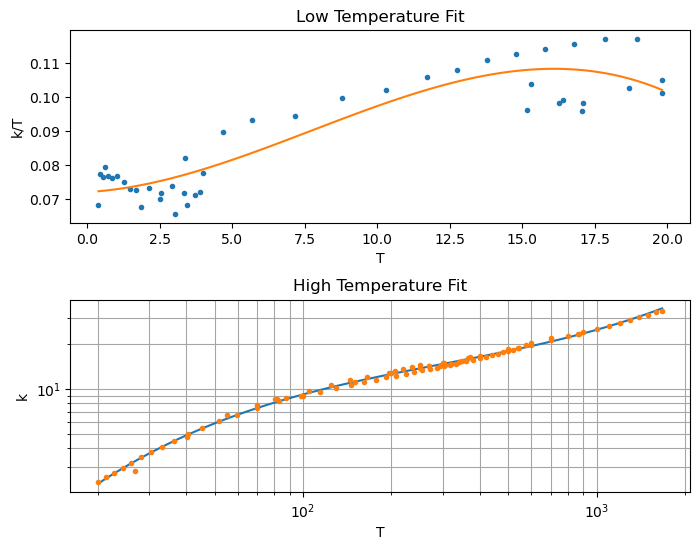

{'low_function_type': '3 order k/T', 'low_fit_param': [-1.547128998890943e-05, 0.0003585848106280745, 0.0004858976514180829, 0.07216880501336798], 'low_fit_range': [0.3846, 19.83], 'hi_function_type': '3 order loglog', 'hi_fit_param': [0.21898264694005085, -1.6295134231352848, 4.420777795436037, -3.1124773982465572], 'hi_fit_range': [20.117000000000004, 1671.9999999999998], 'combined_function_type': 'loglog', 'combined_fit_param': [-1.547128998890943e-05, 0.0003585848106280745, 0.0004858976514180829, 0.07216880501336798, 0.21898264694005085, -1.6295134231352848, 4.420777795436037, -3.1124773982465572, 20.0], 'combined_fit_range': [0.3846, 1672.0]}
[{'Fit Type': '3 order k/T', 'Low Temp': '0.385', 'High Temp': '19.830', 'a': '-0.00002', 'b': '0.00036', 'c': '0.00049', 'd': '0.07217', 'e': '0', 'f': '0', 'g': '0', 'h': '0', 'i': '0'}]
[{'Fit Type': '3 order k/T', 'Low Temp': '0.385', 'High Temp': '19.830', 'a': '-0.00002', 'b': '0.00036', 'c': '0.00049', 'd': '0.07217', 'e': '0', 'f': '0

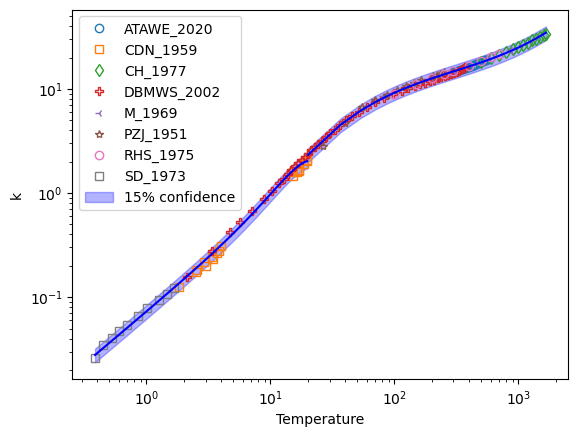

<Figure size 640x480 with 0 Axes>

In [10]:
# for mat in path_to_RAW.keys():
mat = "SS304"

big_data, data_dict = parse_raw(mat, path_to_RAW, plots=False)
fit_args = fit_thermal_conductivity(big_data, os.path.split(path_to_RAW[mat])[0], fit_orders=(3, 3) , plots=True)
print(fit_args)
# make_fit_yaml(fit_args, os.path.split(path_to_RAW[mat])[0])
output_array = make_fit_dictm2(fit_args)
create_data_table(output_array, f"{os.path.split(path_to_RAW[mat])[0]}\\{os.path.split(os.path.split(path_to_RAW[mat])[0])[1]}.txt")
make_fit_lh5(fit_args, os.path.split(path_to_RAW[mat])[0])
tk_plot(mat,path_to_RAW, data_dict, fit_args, points=True)

Finally, lets output a single human readable (and CSV) file of the fits for each material currently in the library.

In [11]:
def make_output_dict(path_to_RAW):
    for mat in path_to_RAW.keys():
        file = os.path.split(path_to_RAW[mat])[0]
        max_fit_param = 0
        with h5py.File(f"{file}\\{mat}.lh5", "r") as material_file:
            num_fit_param = len(np.array(material_file["hi_fit_param"]))
            if num_fit_param > max_fit_param:
                max_fit_param = num_fit_param

    def generate_alphabet_array(n):
        alphabet = list(string.ascii_lowercase)
        return alphabet[:n]

    # Example: Create an array of the first 5 letters of the alphabet
    n = max_fit_param
    result = generate_alphabet_array(n)
    output_array = []
    keys = ["Material", "Fit Type", "Low", "High"] + result
    for mat in path_to_RAW.keys():
        file = os.path.split(path_to_RAW[mat])[0]
        with h5py.File(f"{file}\\{mat}.lh5", "r") as material_file:
            dict_vals = [mat]
            dict_vals = np.append(dict_vals, np.array(material_file["hi_function_type"], dtype=str).flatten())
            dict_vals = np.append(dict_vals, np.char.mod('%0.' + str(3) + 'f', np.array(material_file["hi_fit_range"], dtype=float)).flatten())
            param_str_arr = np.char.mod('%0.' + str(5) + 'f', np.array(material_file["hi_fit_param"], dtype=float)).flatten()
            while len(param_str_arr) < len(result):
                param_str_arr = np.append(param_str_arr, "0")
            dict_vals = np.append(dict_vals, param_str_arr)
            mat_dict = dict(zip(keys, dict_vals))
            output_array.append(mat_dict)

    return output_array

output_array = make_output_dict(path_to_RAW)


In [12]:
# Call the function to create the data table and write to the file
create_data_table(output_array, "thermal_conductivity.txt")
create_tc_csv(output_array, "thermal_conductivity.csv")